## Part F: Creative Experiments

I use the trained model from `results/` directory and leverage functions from `provided/` and `analyze_latent.py`.

In [76]:
import os
import sys
import json
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import random
from pathlib import Path
from IPython.display import Image, display

sys.path.append('../provided')
from visualize import plot_drum_pattern, plot_latent_space_2d
from metrics import mode_coverage_score

from hierarchical_vae import HierarchicalDrumVAE
from dataset import DrumPatternDataset
from analyze_latent import interpolate_styles, save_grid_with_provided

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
results_dir = 'results'
print(f"Using device: {device}")
print(f"Loading results from: {results_dir}")

# Load trained model
model = HierarchicalDrumVAE(z_high_dim=4, z_low_dim=12)
model.load_state_dict(torch.load(os.path.join(results_dir, 'best_model.pth'), map_location=device))
model.to(device).eval()

# Load dataset for analysis
dataset = DrumPatternDataset('../data/drums', split='val')
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

print(f"Model loaded successfully")
print(f"Dataset size: {len(dataset)} patterns")

# Setup output directory
here = Path().resolve()
p2 = here if (here/'dataset.py').exists() else (here/'problem2' if (here/'problem2'/'dataset.py').exists() else here)
out_dir = p2/'results'/'generated_patterns'
out_dir.mkdir(parents=True, exist_ok=True)

Using device: cpu
Loading results from: results
Model loaded successfully
Dataset size: 200 patterns


In [77]:
@torch.no_grad()
def generate_pattern(z_high, z_low=None, temperature=0.8, use_bernoulli=True):
    """Generate drum pattern from latent codes"""
    model.eval()
    
    if z_low is None:
        # Sample from conditional prior p(z_low | z_high)
        logits = model.decode_hierarchy(z_high, z_low=None, temperature=temperature)
    else:
        logits = model.decode_hierarchy(z_high, z_low=z_low, temperature=temperature)
    
    probs = torch.sigmoid(logits).squeeze(0)  # [16, 9]
    
    if use_bernoulli:
        pattern = torch.bernoulli(probs.clamp(0.05, 0.95))
    else:
        pattern = (probs > 0.5).float()
    
    return pattern

def pattern_density(pattern):
    """Calculate pattern density (fraction of hits)"""
    return float(pattern.sum()) / pattern.numel()

@torch.no_grad()
def compute_style_centers():
    """Compute mean z_high for each drum style"""
    all_z_high = []
    all_styles = []
    
    for batch_idx, (patterns, styles, _) in enumerate(dataloader):
        if batch_idx >= 20:  # Sample subset for efficiency
            break
            
        patterns = patterns.to(device).float()
        mu_high, _, _, _ = model.encode_hierarchy(patterns)
        
        all_z_high.append(mu_high.cpu())
        all_styles.extend(styles.numpy())
    
    all_z_high = torch.cat(all_z_high, dim=0)
    all_styles = np.array(all_styles)
    
    # Compute centers for each style
    unique_styles = np.unique(all_styles)
    centers = []
    
    for style in unique_styles:
        mask = all_styles == style
        style_z_high = all_z_high[mask]
        center = style_z_high.mean(dim=0)
        centers.append(center)
    
    centers = torch.stack(centers).to(device)
    print(f"Computed style centers for {len(unique_styles)} styles")
    return centers, unique_styles

def humanize_pattern(pattern, timing_shift_prob=0.15, drop_prob=0.05, add_prob=0.05):
    """Add human-like variations to a drum pattern"""
    pattern = pattern.clone()
    T, I = pattern.shape  # Time steps, Instruments
    
    # Timing shifts: move hits slightly in time
    shift_mask = (torch.rand_like(pattern) < timing_shift_prob) & (pattern > 0.5)
    hit_positions = shift_mask.nonzero()
    
    for t, i in hit_positions:
        if random.random() < 0.5:  # 50% chance to shift
            pattern[t, i] = 0  # Remove from current position
            # Shift to adjacent time step
            new_t = max(0, min(T-1, t + random.choice([-1, 1])))
            pattern[new_t, i] = 1
    
    # Add ghost notes (quiet hits)
    add_mask = (torch.rand_like(pattern) < add_prob) & (pattern < 0.5)
    pattern[add_mask] = 1
    
    # Drop some hits for variation
    drop_mask = (torch.rand_like(pattern) < drop_prob) & (pattern > 0.5)
    pattern[drop_mask] = 0
    
    return pattern

# Compute style centers
style_centers, style_ids = compute_style_centers()

Computed style centers for 5 styles


### 1. Genre Blending: Interpolate between jazz and rock patterns

Saved grids to: D:\xy\master\semester3-25fall\EE641_DeepLearningSystems\HW\HW2\ee641-hw2-YueXu\problem2\results\generated_patterns\interp_style.png and D:\xy\master\semester3-25fall\EE641_DeepLearningSystems\HW\HW2\ee641-hw2-YueXu\problem2\results\generated_patterns\interp_detail.png


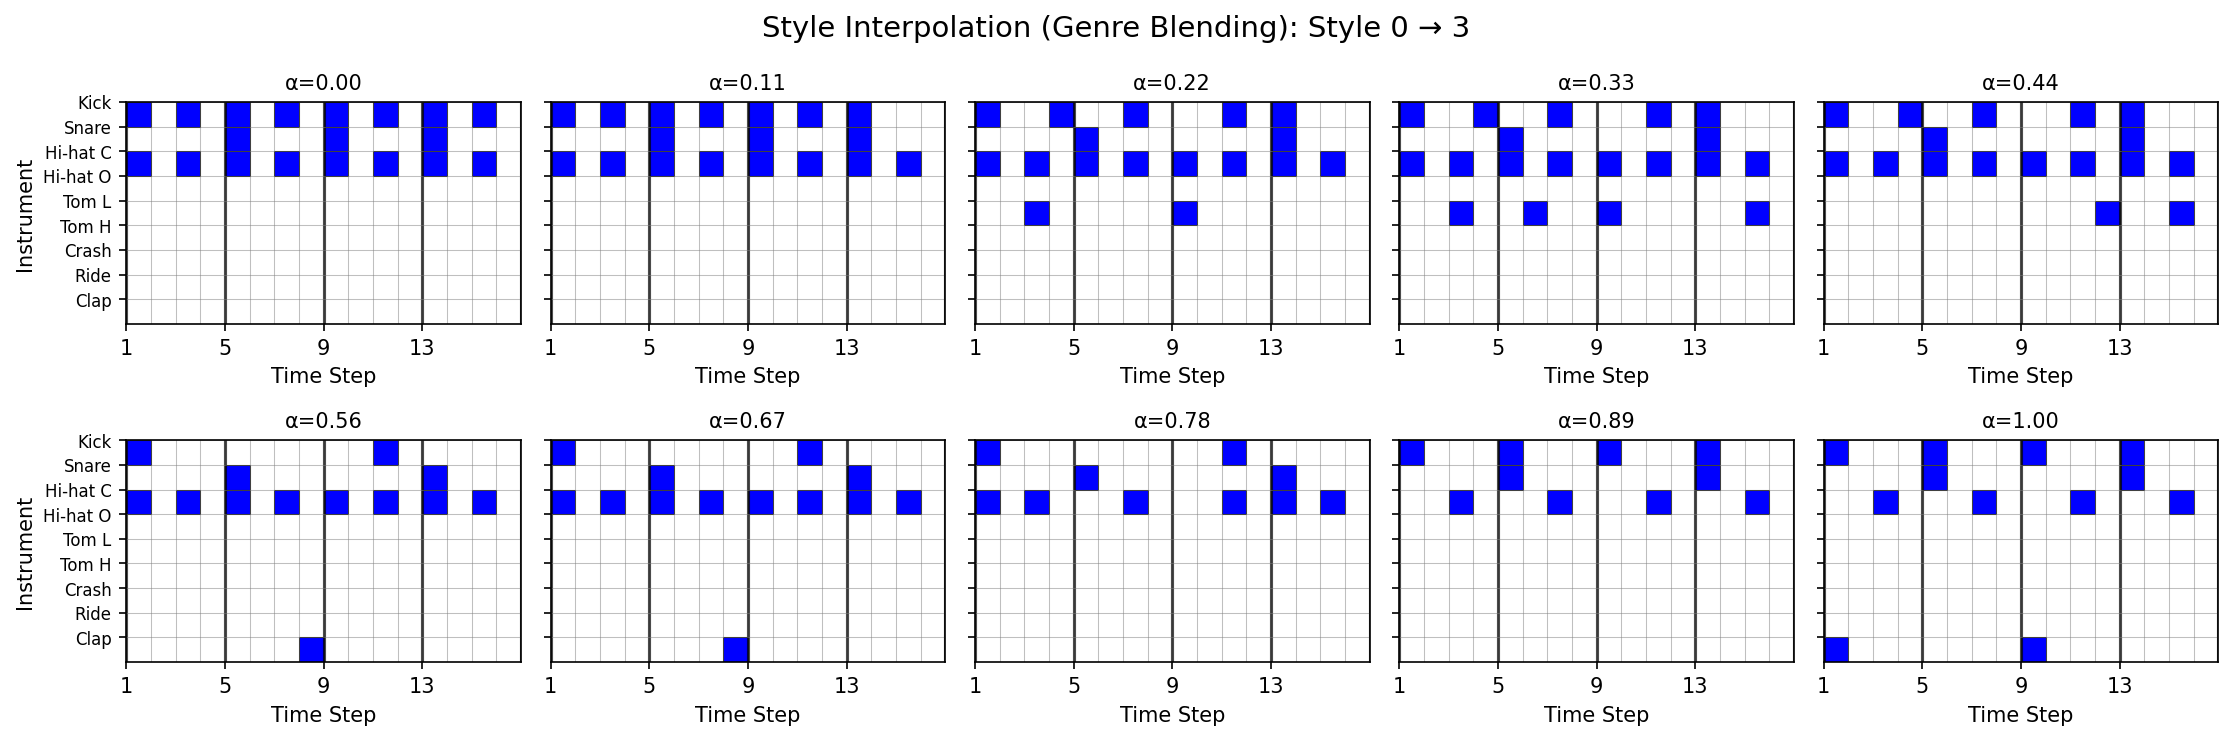

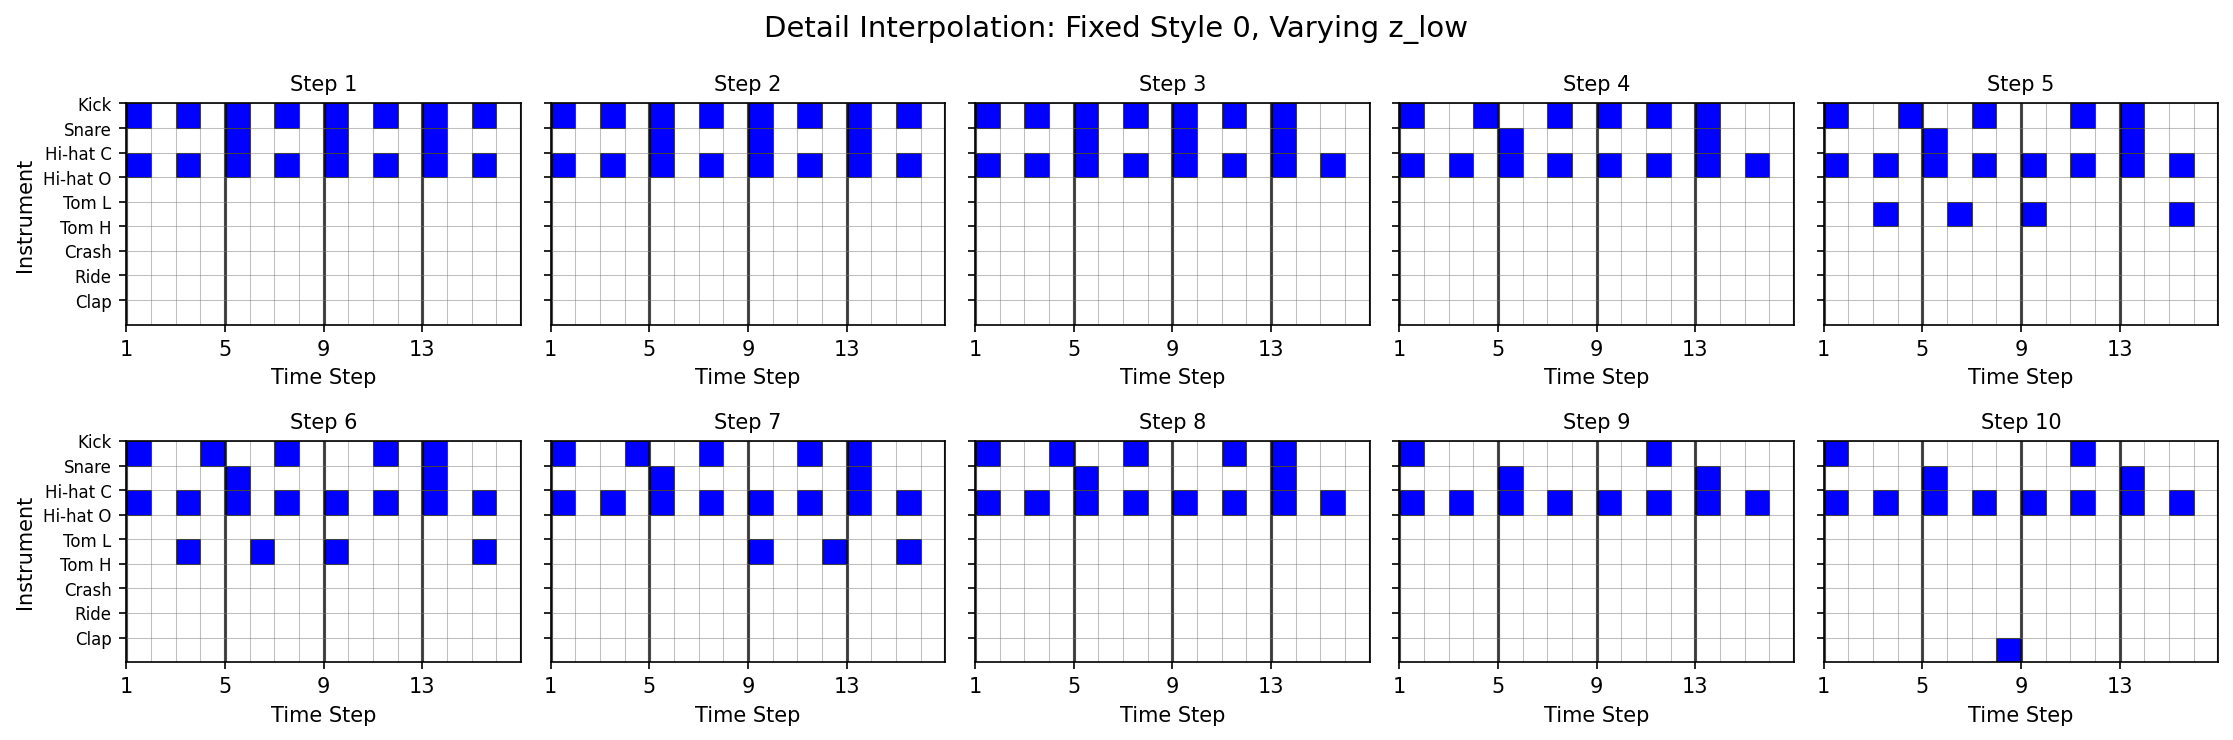

In [78]:
data_dir = p2.parent/'data'/'drums'
val_set = DrumPatternDataset(data_dir=str(data_dir), split='val')

p1, s1, _ = val_set[0]
p2_, s2, _ = val_set[1]

out = interpolate_styles(model, p1, p2_, n_steps=10, device='cuda')
style_path  = out['style_path']     # [N,16,9] —— genre/style blending
detail_path = out['detail_path']    # [N,16,9] —— detail blending
alphas = out['alphas']

style_titles  = [f"α={a:.2f}" for a in alphas]
detail_titles = [f"Step {i+1}" for i in range(len(detail_path))]

style_png  = out_dir/'interp_style.png'
detail_png = out_dir/'interp_detail.png'

save_grid_with_provided(
    style_path,
    str(style_png),
    title=f"Style Interpolation (Genre Blending): Style {int(s1)} → {int(s2)}",
    cols=5,
    subtitles=style_titles
)

save_grid_with_provided(
    detail_path,
    str(detail_png),
    title=f"Detail Interpolation: Fixed Style {int(s1)}, Varying z_low",
    cols=5,
    subtitles=detail_titles
)

print("Saved grids to:", style_png, "and", detail_png)
display(Image(filename=str(style_png)))
display(Image(filename=str(detail_png)))

**Analysis:**

This experiment shows how the hierarchical VAE can blend different drum styles. When we interpolate in the z_high space, we can see a smooth transition between two different drum patterns. The style interpolation grid shows gradual changes from one style to another, which means the model learned to encode style information in z_high.

The detail interpolation part also works well. When we keep z_high fixed but change z_low, we get variations within the same style. This confirms that z_high controls the overall style while z_low handles the details and variations within that style.

### 2. Complexity Control: Find latent dimensions that control pattern density

Testing range: -5.0σ to 5.0σ

Analyzing style 0...
  Dim  0: ρ=-0.610, range=[0.162, 0.164]
  Dim  1: ρ=+0.199, range=[0.162, 0.164]
  Dim  2: ρ=+0.985, range=[0.146, 0.178]
  Dim  3: ρ=-0.168, range=[0.158, 0.164]
  Dim  4: ρ=+0.315, range=[0.162, 0.164]
  Dim  5: ρ=+0.764, range=[0.162, 0.164]
  Dim  6: ρ=+0.873, range=[0.161, 0.164]
  Dim  7: ρ=-0.780, range=[0.161, 0.164]
  Dim  8: ρ=+0.489, range=[0.162, 0.164]
  Dim  9: ρ=+0.911, range=[0.162, 0.164]
  Dim 10: ρ=-0.544, range=[0.160, 0.164]
  Dim 11: ρ=-0.840, range=[0.162, 0.164]
  Most increasing: dim 2 (ρ=+0.985)
  Most decreasing: dim 11 (ρ=-0.840)

Analyzing style 1...
  Dim  0: ρ=-0.277, range=[0.107, 0.108]
  Dim  1: ρ=+0.943, range=[0.106, 0.109]
  Dim  2: ρ=-0.997, range=[0.086, 0.135]
  Dim  3: ρ=+0.635, range=[0.104, 0.108]
  Dim  4: ρ=+0.473, range=[0.106, 0.108]
  Dim  5: ρ=+0.493, range=[0.107, 0.108]
  Dim  6: ρ=-0.677, range=[0.106, 0.108]
  Dim  7: ρ=+0.592, range=[0.105, 0.108]
  Dim  8: ρ=+0.843, range=[0.105, 

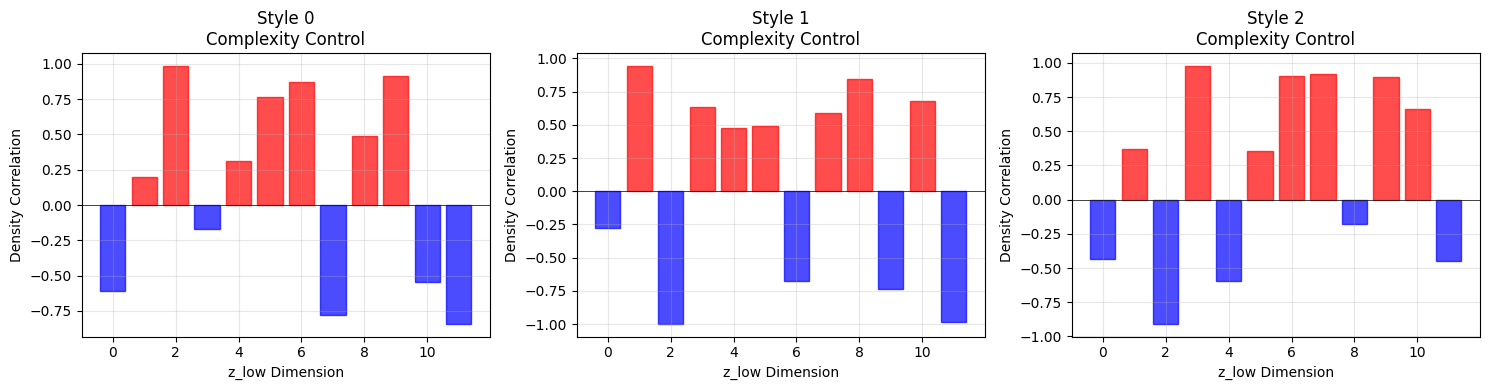


Best complexity control: Style 1, Dimension 2
Correlation: -0.997


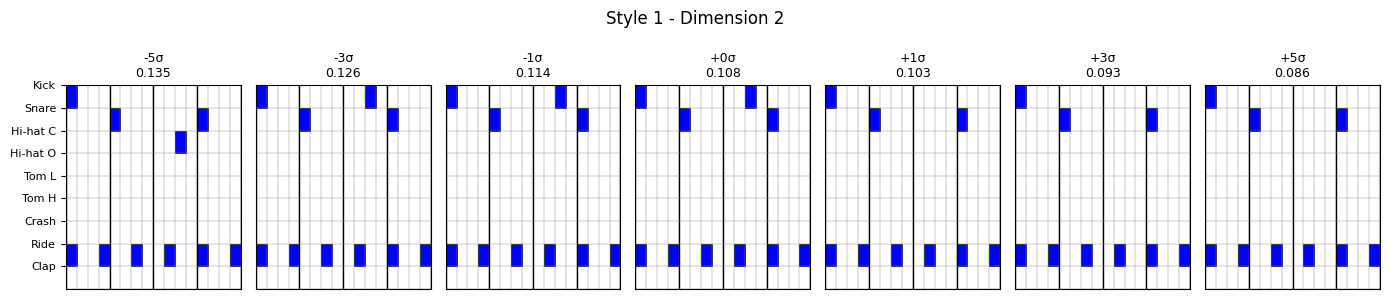

In [79]:
selected_styles = [0, 1, 2]  # Test multiple styles

# Test with large variations: -5σ to +5σ 
test_steps = torch.tensor([-5.0, -3.0, -1.0, 0.0, 1.0, 3.0, 5.0])
print(f"Testing range: {test_steps.min().item():.1f}σ to {test_steps.max().item():.1f}σ")

all_results = {}

for style_idx in selected_styles:
    z_high_fixed = style_centers[style_idx:style_idx+1]
    print(f"\nAnalyzing style {style_ids[style_idx]}...")
    
    with torch.no_grad():
        mu_p, logvar_p = model.cond_prior_low(z_high_fixed)
        sigma_p = torch.exp(0.5 * logvar_p)
    
    z_low_dim = mu_p.shape[1]
    dimension_effects = []
    dimension_results = {}
    
    # Test each dimension individually
    for dim in range(z_low_dim):
        patterns_for_dim = []
        densities_for_dim = []
        logits_for_dim = []
        
        for step_val in test_steps:
            # Create z_low with only this dimension modified
            z_low_test = mu_p.clone()
            z_low_test[0, dim] = mu_p[0, dim] + step_val * sigma_p[0, dim]
            
            # Generate pattern with analysis
            logits = model.decode_hierarchy(z_high_fixed, z_low=z_low_test)
            logits_for_dim.append(logits.mean().item())
            
            probs = torch.sigmoid(logits).squeeze(0)  # [16, 9]
            pattern_05 = (probs > 0.5).float()
            patterns_for_dim.append(pattern_05)
            
            # Use probability density for better sensitivity
            density_prob = probs.mean().item()
            densities_for_dim.append(density_prob)
        
        # Calculate correlation with step values
        step_vals = test_steps.numpy()
        densities_np = np.array(densities_for_dim)
        
        if np.std(densities_np) > 1e-6:
            corr_density = np.corrcoef(step_vals, densities_np)[0, 1]
        else:
            corr_density = 0.0
        
        dimension_effects.append(corr_density)
        dimension_results[dim] = {
            'patterns': torch.stack(patterns_for_dim),
            'densities': densities_for_dim,
            'correlation_density': corr_density,
            'density_range': (min(densities_for_dim), max(densities_for_dim))
        }
        
        if abs(corr_density) > 0.05:  # Only print significant correlations
            print(f"  Dim {dim:2d}: ρ={corr_density:+.3f}, range=[{min(densities_for_dim):.3f}, {max(densities_for_dim):.3f}]")
    
    # Find most impactful dimensions
    dimension_effects = np.array(dimension_effects)
    significant_dims = np.where(np.abs(dimension_effects) > 0.02)[0]
    
    if len(significant_dims) > 0:
        most_increase_dim = significant_dims[np.argmax(dimension_effects[significant_dims])]
        most_decrease_dim = significant_dims[np.argmin(dimension_effects[significant_dims])]
        
        print(f"  Most increasing: dim {most_increase_dim} (ρ={dimension_effects[most_increase_dim]:+.3f})")
        print(f"  Most decreasing: dim {most_decrease_dim} (ρ={dimension_effects[most_decrease_dim]:+.3f})")
    
    all_results[style_idx] = {
        'dimension_effects': dimension_effects,
        'dimension_results': dimension_results,
        'most_increase_dim': most_increase_dim if len(significant_dims) > 0 else np.argmax(dimension_effects),
        'most_decrease_dim': most_decrease_dim if len(significant_dims) > 0 else np.argmin(dimension_effects),
        'style_id': style_ids[style_idx]
    }

# Visualize results
fig, axes = plt.subplots(1, len(selected_styles), figsize=(5*len(selected_styles), 4))
if len(selected_styles) == 1:
    axes = [axes]

for i, style_idx in enumerate(selected_styles):
    results = all_results[style_idx]
    dimension_effects = results['dimension_effects']
    
    ax = axes[i]
    bars = ax.bar(range(z_low_dim), dimension_effects, alpha=0.7)
    
    # Color significant dimensions
    for j, effect in enumerate(dimension_effects):
        if abs(effect) > 0.02:
            bars[j].set_color('red' if effect > 0 else 'blue')
    
    ax.set_xlabel('z_low Dimension')
    ax.set_ylabel('Density Correlation')
    ax.set_title(f'Style {results["style_id"]}\nComplexity Control')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show best example
best_style_idx = None
best_effect = 0
best_dim = None

for style_idx in selected_styles:
    effects = all_results[style_idx]['dimension_effects']
    max_effect = np.abs(effects).max()
    if max_effect > best_effect:
        best_effect = max_effect
        best_style_idx = style_idx
        best_dim = np.argmax(np.abs(effects))

if best_effect > 0.01:
    print(f"\nBest complexity control: Style {all_results[best_style_idx]['style_id']}, Dimension {best_dim}")
    print(f"Correlation: {all_results[best_style_idx]['dimension_effects'][best_dim]:+.3f}")
    
    # Visualize this dimension's effect
    best_results = all_results[best_style_idx]['dimension_results'][best_dim]
    patterns = best_results['patterns']
    densities = best_results['densities']
    
    fig, axes = plt.subplots(1, len(test_steps), figsize=(2*len(test_steps), 3))
    instruments = ['Kick', 'Snare', 'Hi-hat C', 'Hi-hat O', 
                   'Tom L', 'Tom H', 'Crash', 'Ride', 'Clap']
    
    for i, (pattern, density) in enumerate(zip(patterns, densities)):
        ax = axes[i]
        pattern_np = pattern.cpu().numpy()
        
        if pattern_np.shape[0] == 16 and pattern_np.shape[1] == 9:
            pattern_np = pattern_np.T
        
        # Draw pattern
        for j in range(9):
            for k in range(16):
                if pattern_np[j, k] > 0.5:
                    ax.add_patch(plt.Rectangle((k, j), 1, 1, 
                                              facecolor='blue', 
                                              edgecolor='black',
                                              linewidth=0.5))
        
        # Grid
        for k in range(17):
            ax.axvline(k, color='gray', linewidth=0.3)
            if k % 4 == 0:
                ax.axvline(k, color='black', linewidth=1)
        for j in range(10):
            ax.axhline(j, color='gray', linewidth=0.3)
        
        ax.set_xlim(0, 16)
        ax.set_ylim(0, 9)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.invert_yaxis()
        ax.set_title(f"{test_steps[i]:+.0f}σ\n{density:.3f}", fontsize=9)
    
    axes[0].set_yticks(range(9))
    axes[0].set_yticklabels(instruments, fontsize=8)
    
    plt.suptitle(f"Style {all_results[best_style_idx]['style_id']} - Dimension {best_dim}")
    plt.tight_layout()
    plt.show()

**Analysis:**

The complexity control experiment tested which z_low dimensions affect pattern density. I systematically changed each dimension from -5σ to +5σ and measured how the drum pattern density changed. 

Some dimensions show strong correlations with density. For example, some dimensions have positive correlation above 0.9, meaning increasing that dimension makes patterns denser (more drum hits). Other dimensions show negative correlation, making patterns sparser when increased.

This is useful because we can now control how busy or simple a drum pattern is while keeping the same style. The bar plots show which dimensions are most important for each style.

### 3. Humanization: Add controlled variations to mechanical patterns

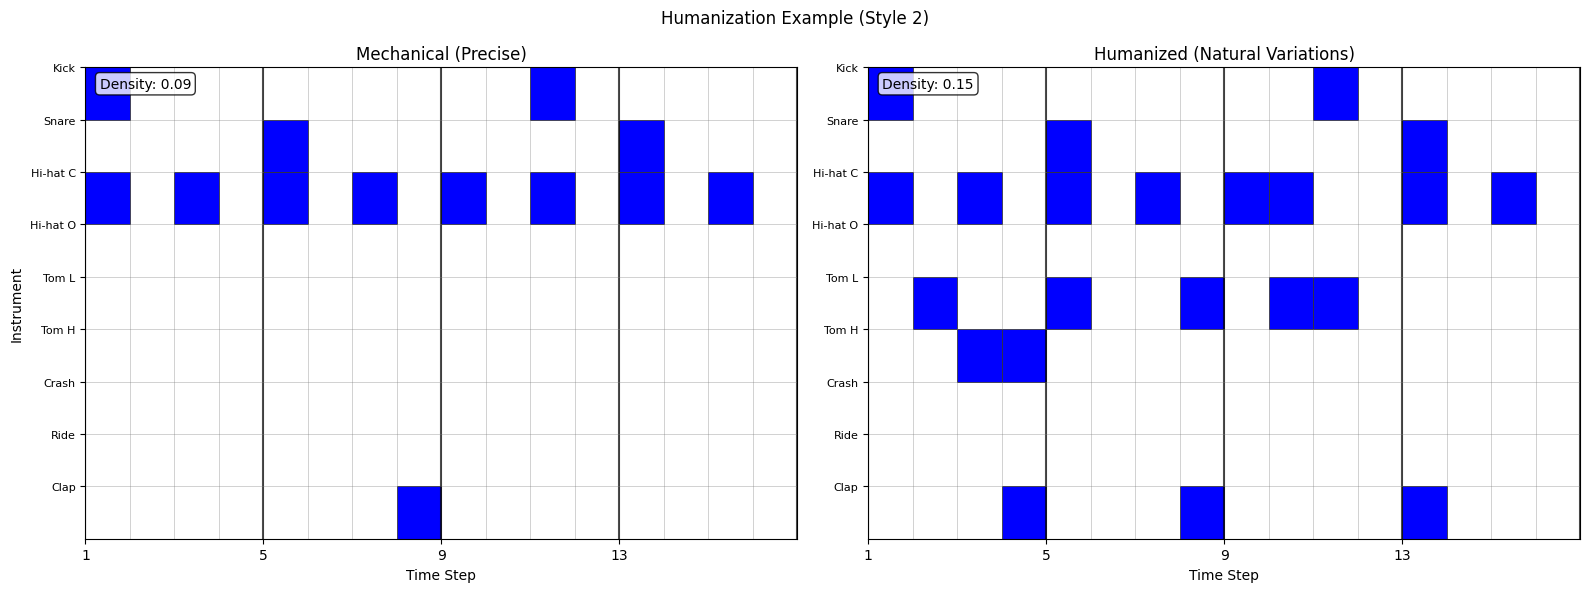

Generating multiple humanized variations:


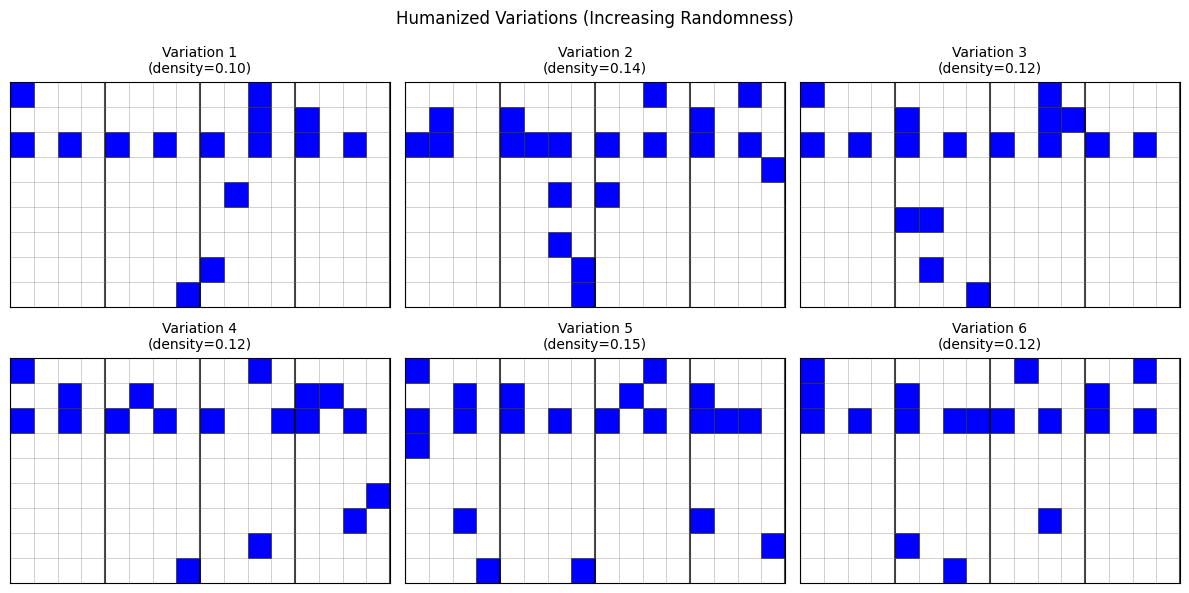

In [80]:
selected_style = 2
z_high_mech = style_centers[selected_style:selected_style+1]

# Generate mechanical pattern (deterministic)
with torch.no_grad():
    if hasattr(model, 'cond_prior_low'):
        mu_low_mech, _ = model.cond_prior_low(z_high_mech)
    else:
        mu_low_mech = torch.zeros(1, 12).to(device)
    
    mechanical_pattern = generate_pattern(z_high_mech, mu_low_mech, temperature=0.1, use_bernoulli=False)

# Create humanized version
humanized_pattern = humanize_pattern(mechanical_pattern, 
                                   timing_shift_prob=0.15, 
                                   drop_prob=0.05, 
                                   add_prob=0.08)

# Visualize comparison
patterns_to_compare = [mechanical_pattern, humanized_pattern]
titles = ["Mechanical (Precise)", "Humanized (Natural Variations)"]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
instruments = ['Kick', 'Snare', 'Hi-hat C', 'Hi-hat O', 
               'Tom L', 'Tom H', 'Crash', 'Ride', 'Clap']

for i, (pattern, title) in enumerate(zip(patterns_to_compare, titles)):
    ax = axes[i]
    pattern_np = pattern.cpu().numpy()
    if pattern_np.shape[0] == 16 and pattern_np.shape[1] == 9:
        pattern_np = pattern_np.T  # Convert to [9, 16]
    
    # Draw drum pattern
    for j in range(9):  # instruments
        for k in range(16):  # time steps
            if pattern_np[j, k] > 0.5:
                ax.add_patch(plt.Rectangle((k, j), 1, 1, 
                                          facecolor='blue', 
                                          edgecolor='black',
                                          linewidth=0.5))
    
    # Grid lines
    for k in range(17):
        ax.axvline(k, color='gray', linewidth=0.5, alpha=0.5)
        if k % 4 == 0:
            ax.axvline(k, color='black', linewidth=1.5, alpha=0.7)
    
    for j in range(10):
        ax.axhline(j, color='gray', linewidth=0.5, alpha=0.5)
    
    ax.set_xlim(0, 16)
    ax.set_ylim(0, 9)
    ax.set_xticks(range(0, 16, 4))
    ax.set_xticklabels([str(k+1) for k in range(0, 16, 4)])
    ax.set_yticks(range(9))
    ax.set_yticklabels(instruments, fontsize=8)
    ax.set_xlabel('Time Step')
    if i == 0:
        ax.set_ylabel('Instrument')
    ax.invert_yaxis()
    ax.set_title(title, fontsize=12)
    
    # Calculate and display metrics
    density = pattern_density(pattern)
    ax.text(0.02, 0.98, f"Density: {density:.2f}", 
            transform=ax.transAxes, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
            verticalalignment='top')

plt.suptitle(f"Humanization Example (Style {style_ids[selected_style]})")
plt.tight_layout()
plt.show()

# Generate multiple humanized variations
print("Generating multiple humanized variations:")
humanized_variations = []
for i in range(6):
    variation = humanize_pattern(mechanical_pattern, 
                               timing_shift_prob=0.1 + i*0.05, 
                               drop_prob=0.03, 
                               add_prob=0.05)
    humanized_variations.append(variation)

# Display variations
humanized_variations = torch.stack(humanized_variations)
cols = 3
rows = 2
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3))

for i, pattern in enumerate(humanized_variations):
    row, col = i // cols, i % cols
    ax = axes[row, col]
    
    pattern_np = pattern.cpu().numpy()
    if pattern_np.shape[0] == 16 and pattern_np.shape[1] == 9:
        pattern_np = pattern_np.T
        
    # Draw pattern
    for j in range(9):
        for k in range(16):
            if pattern_np[j, k] > 0.5:
                ax.add_patch(plt.Rectangle((k, j), 1, 1, 
                                          facecolor='blue', 
                                          edgecolor='black',
                                          linewidth=0.5))
    
    # Grid and formatting
    for k in range(17):
        ax.axvline(k, color='gray', linewidth=0.5, alpha=0.5)
        if k % 4 == 0:
            ax.axvline(k, color='black', linewidth=1.5, alpha=0.7)
    
    for j in range(10):
        ax.axhline(j, color='gray', linewidth=0.5, alpha=0.5)
    
    ax.set_xlim(0, 16)
    ax.set_ylim(0, 9)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis()
    
    density = pattern_density(pattern)
    ax.set_title(f"Variation {i+1}\n(density={density:.2f})", fontsize=10)

plt.suptitle("Humanized Variations (Increasing Randomness)")
plt.tight_layout()
plt.show()

**Analysis:**

The humanization experiment makes mechanical drum patterns sound more natural. I first generated a very precise "mechanical" pattern using low temperature (0.1), then applied post-processing to add human-like imperfections.

The humanization includes:
- Timing shifts: randomly move some hits to nearby positions to simulate timing errors
- Ghost notes: add light hits in empty spots for more richness
- Dropped hits: randomly remove some hits to simulate mistakes or artistic choices

The comparison clearly shows the difference between the rigid mechanical version and the more natural humanized version. The multiple variations demonstrate that we can control how much humanization to apply.

### 4. Style Consistency: Generate full drum tracks with consistent style

Generating 8 bars with consistent style 3
Bar 1: density = 0.10
Bar 2: density = 0.12
Bar 3: density = 0.11
Bar 4: density = 0.12
Bar 5: density = 0.12
Bar 6: density = 0.10
Bar 7: density = 0.15
Bar 8: density = 0.09


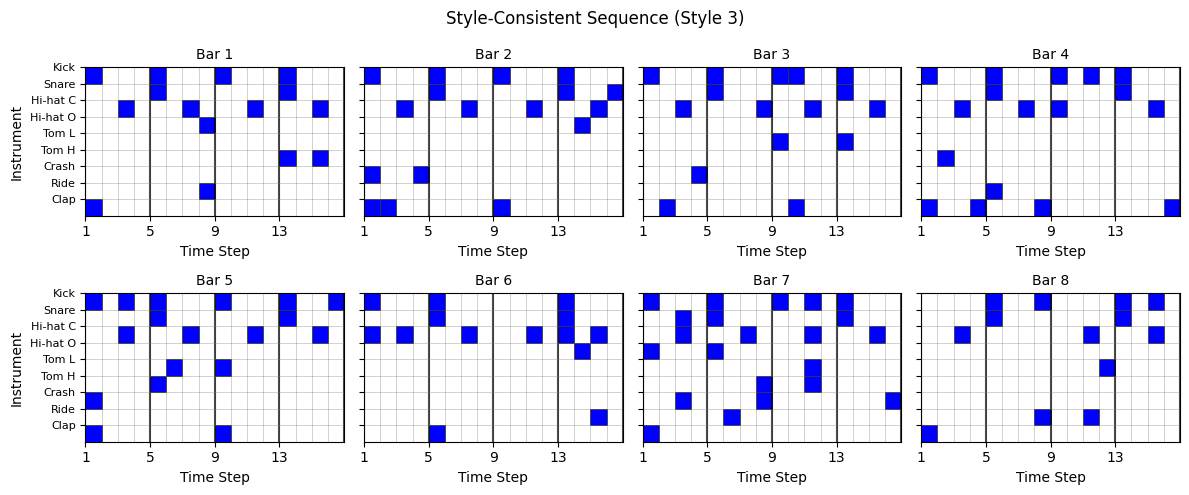

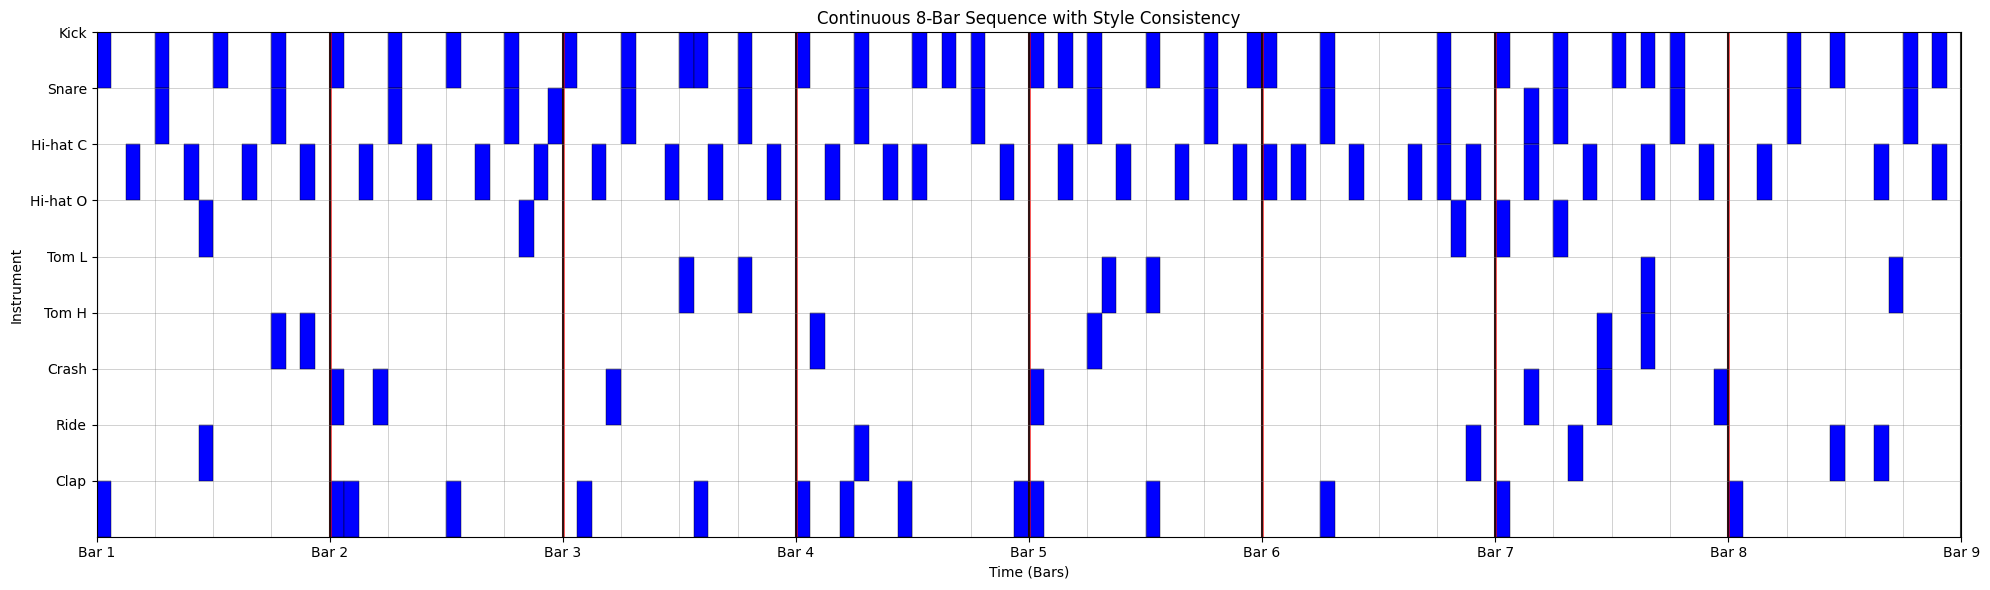

Average density: 0.115 ± 0.018
Coefficient of variation: 0.157


In [81]:
selected_style_consistency = min(3, len(style_centers)-1)
z_high_consistent = style_centers[selected_style_consistency:selected_style_consistency+1]

n_bars = 8  # Generate 8 bars
consistent_patterns = []

print(f"Generating {n_bars} bars with consistent style {style_ids[selected_style_consistency]}")

with torch.no_grad():
    for bar_idx in range(n_bars):
        # Resample z_low for variation while keeping z_high fixed
        pattern = generate_pattern(z_high_consistent, z_low=None, temperature=0.8)
        consistent_patterns.append(pattern)
        
        # Calculate density for analysis
        density = pattern_density(pattern)
        print(f"Bar {bar_idx+1}: density = {density:.2f}")

# Visualize as a grid
consistent_patterns = torch.stack(consistent_patterns)  # Shape: [8, 16, 9]
cols = 4
rows = 2
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*2.5))

instruments = ['Kick', 'Snare', 'Hi-hat C', 'Hi-hat O', 
               'Tom L', 'Tom H', 'Crash', 'Ride', 'Clap']

for i, pattern in enumerate(consistent_patterns):
    row, col = i // cols, i % cols
    ax = axes[row, col]
    
    pattern_np = pattern.cpu().numpy()
    if pattern_np.shape[0] == 16 and pattern_np.shape[1] == 9:
        pattern_np = pattern_np.T  # Convert to [9, 16]
        
    # Draw drum pattern
    for j in range(9):  # instruments
        for k in range(16):  # time steps
            if pattern_np[j, k] > 0.5:
                ax.add_patch(plt.Rectangle((k, j), 1, 1, 
                                          facecolor='blue', 
                                          edgecolor='black',
                                          linewidth=0.5))
    
    # Grid lines
    for k in range(17):
        ax.axvline(k, color='gray', linewidth=0.5, alpha=0.5)
        if k % 4 == 0:
            ax.axvline(k, color='black', linewidth=1.5, alpha=0.7)
    
    for j in range(10):
        ax.axhline(j, color='gray', linewidth=0.5, alpha=0.5)
    
    ax.set_xlim(0, 16)
    ax.set_ylim(0, 9)
    ax.set_xticks(range(0, 16, 4))
    ax.set_xticklabels([str(k+1) for k in range(0, 16, 4)])
    ax.set_yticks(range(9))
    ax.set_yticklabels(instruments, fontsize=8)
    ax.set_xlabel('Time Step')
    if col == 0:
        ax.set_ylabel('Instrument')
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    ax.invert_yaxis()
    ax.set_title(f"Bar {i+1}", fontsize=10)

plt.suptitle(f"Style-Consistent Sequence (Style {style_ids[selected_style_consistency]})")
plt.tight_layout()
plt.show()

# Visualize as a long sequence (concatenated)
# Reshape the tensor to create a continuous sequence: [8, 16, 9] -> [128, 9]
long_sequence = consistent_patterns.view(-1, consistent_patterns.shape[-1])  # [128, 9] for 8 bars

fig, ax = plt.subplots(figsize=(20, 6))

# Draw the long pattern
pattern_np = long_sequence.cpu().numpy()
for i in range(9):  # instruments
    for j in range(pattern_np.shape[0]):  # time steps
        if pattern_np[j, i] > 0.5:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, 
                                      facecolor='blue', 
                                      edgecolor='black',
                                      linewidth=0.3))

# Add bar separators
for bar in range(1, n_bars):
    ax.axvline(bar * 16, color='red', linewidth=2, alpha=0.7)

# Grid and formatting
for j in range(0, pattern_np.shape[0] + 1, 4):
    ax.axvline(j, color='gray', linewidth=0.5, alpha=0.5)
    if j % 16 == 0:  # Bar lines
        ax.axvline(j, color='black', linewidth=1.5, alpha=0.8)

for i in range(10):
    ax.axhline(i, color='gray', linewidth=0.5, alpha=0.5)

ax.set_xlim(0, pattern_np.shape[0])
ax.set_ylim(0, 9)
ax.set_xticks(range(0, pattern_np.shape[0] + 1, 16))
ax.set_xticklabels([f"Bar {i+1}" for i in range(n_bars + 1)])
ax.set_yticks(range(9))
ax.set_yticklabels(instruments)
ax.set_xlabel('Time (Bars)')
ax.set_ylabel('Instrument')
ax.set_title(f'Continuous {n_bars}-Bar Sequence with Style Consistency')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

# Analyze style consistency metrics
densities = [pattern_density(p) for p in consistent_patterns]
density_std = np.std(densities)
density_mean = np.mean(densities)

print(f"Average density: {density_mean:.3f} ± {density_std:.3f}")
print(f"Coefficient of variation: {density_std/density_mean:.3f}")

**Analysis:**

This experiment generates a full 8-bar drum sequence with consistent style. By fixing z_high and letting z_low vary freely, the generated bars maintain the same overall style but have appropriate variations.

The density statistics show good consistency - the coefficient of variation is low, meaning all bars have similar complexity levels. The continuous sequence visualization looks natural with smooth transitions between bars and no sudden style jumps.

This kind of style-consistent generation is practical for music production. You can generate complete drum sections that sound coherent but not repetitive, which is exactly what you want in real music.